In [1]:
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
set.seed(19)
## Load data
pulsar_data <- read_csv("https://github.com/kseniak1/DSCI100-Group-Project/raw/main/HTRU_2%5B1%5D.csv", col_names = FALSE) %>%
                ## Rename Columns
                rename(mean_ip = X1,
                      dev_ip = X2,
                      excess_ip = X3,
                      skewness_ip = X4,
                      mean_dm = X5,
                      dev_dm = X6,
                      excess_dm = X7,
                      skewness_dm = X8,
                      class = X9) %>%
                ## Class as a factor
                mutate(class = as.factor(class)) %>%
                ## Select a smaller sample, adjusted for equal parts of each class
                group_by(class)
                sample_n(250)                
pulsar_data


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



ERROR: Error: `tbl` must be a data frame, not a double vector.


In [3]:
set.seed(19)
## Split data into training and testing sets
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [4]:
set.seed(19)
## Completing a 5-fold cross-validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

In [5]:
## Base specification, recipe  and workflow (skeleton for all analysis combos)
set.seed(19)
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
            set_engine('kknn') %>%
            set_mode('classification')

ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
### Uncomment below when adding predictors, rename according to graph number
# pulsar_recipe <- recipe(class ~ mean_ip/dm + predictor_2, data = pulsar_train) %>%
#                     step_scale(all_predictors()) +
#                     step_center(all_predictors())

# knn_results <- workflow() %>%
#       add_recipe(pulsar_recipe) %>%
#       add_model(knn_tune) %>%
#       tune_grid(resamples = pulsar_vfold, grid = ks) %>%
#       collect_metrics() %>% 
#       filter(.metric == "accuracy")
# knn_results

# knn_plot <- ggplot(knn_results, aes(x = neighbors, y = mean))+
#       geom_point() +
#       geom_line() +
#       labs(x = "Neighbors", y = "Accuracy Estimate")  +
#       ggtitle("...")
# knn_plot

Six different pairings of variables will be tested:

Integrated Profile:
1. Mean and Standard Deviation
2. Mean and Excess Kurtosis
3. Mean and Skewness

DM-SNR Curve:

4. Mean and Standard Deviation
5. Mean and Excess Kurtosis
6. Mean and Skewness

Each pairing will be tuned and an elbow plot will be used to determine the best neighbor value to use for each pairing

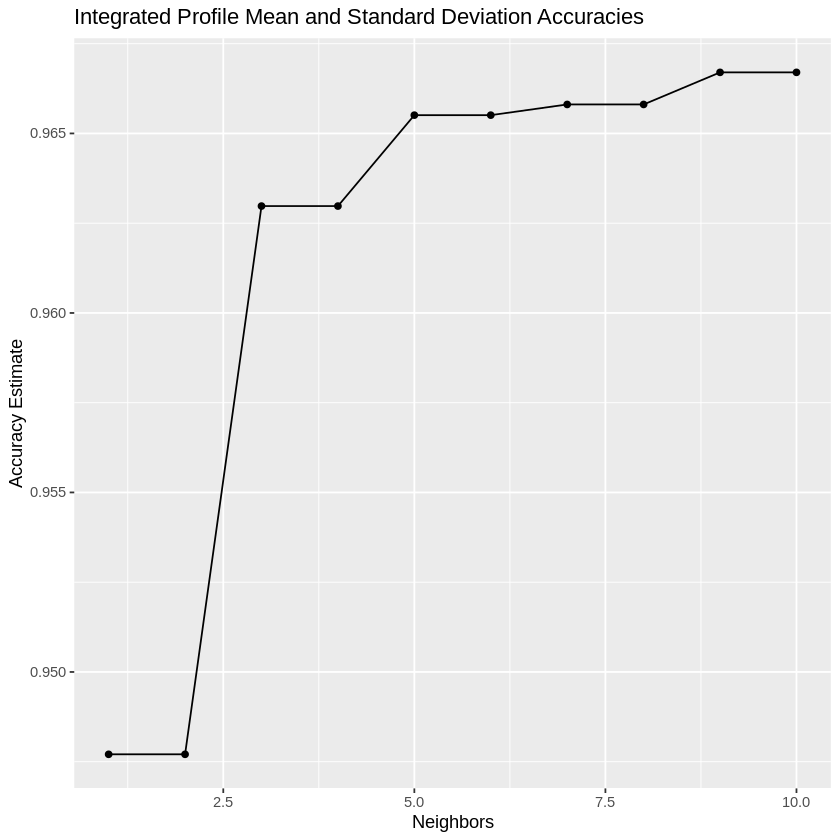

In [6]:
set.seed(19)
## Pairing 1
pulsar_recipe1 <- recipe(class ~ mean_ip + dev_ip, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

knn_results1 <- workflow() %>%
      add_recipe(pulsar_recipe1) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ks) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")

knn_plot1 <- ggplot(knn_results1, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Integrated Profile Mean and Standard Deviation Accuracies")
knn_plot1

k1 <- 3

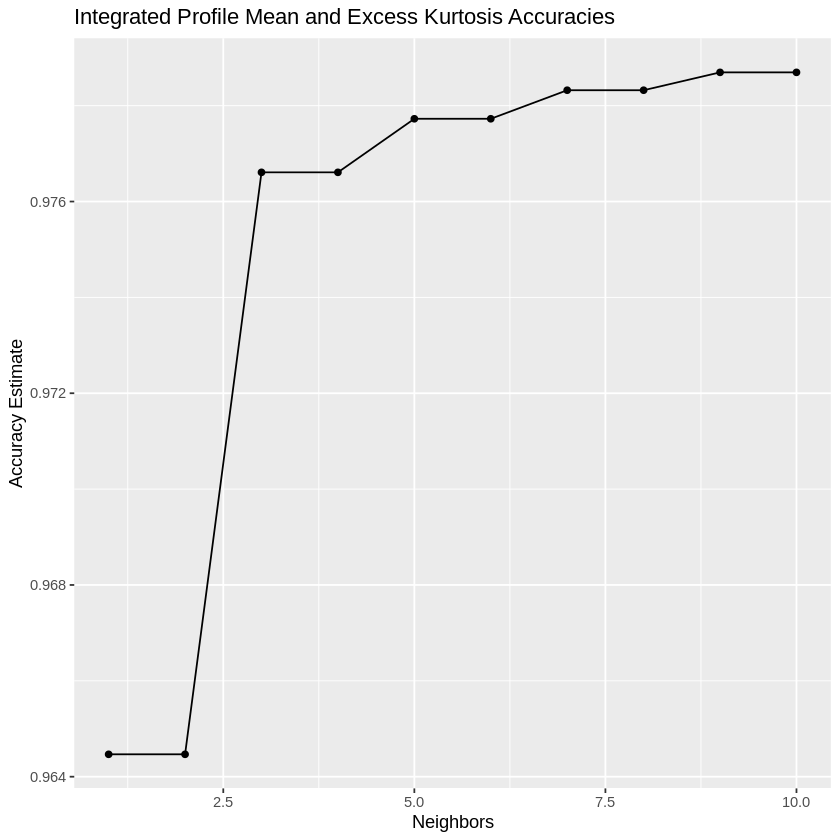

In [7]:
set.seed(19)
## Pairing 2
pulsar_recipe2 <- recipe(class ~ mean_ip + excess_ip, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

knn_results2 <- workflow() %>%
      add_recipe(pulsar_recipe2) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ks) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")

knn_plot2 <- ggplot(knn_results2, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Integrated Profile Mean and Excess Kurtosis Accuracies")
knn_plot2

k2 <- 3

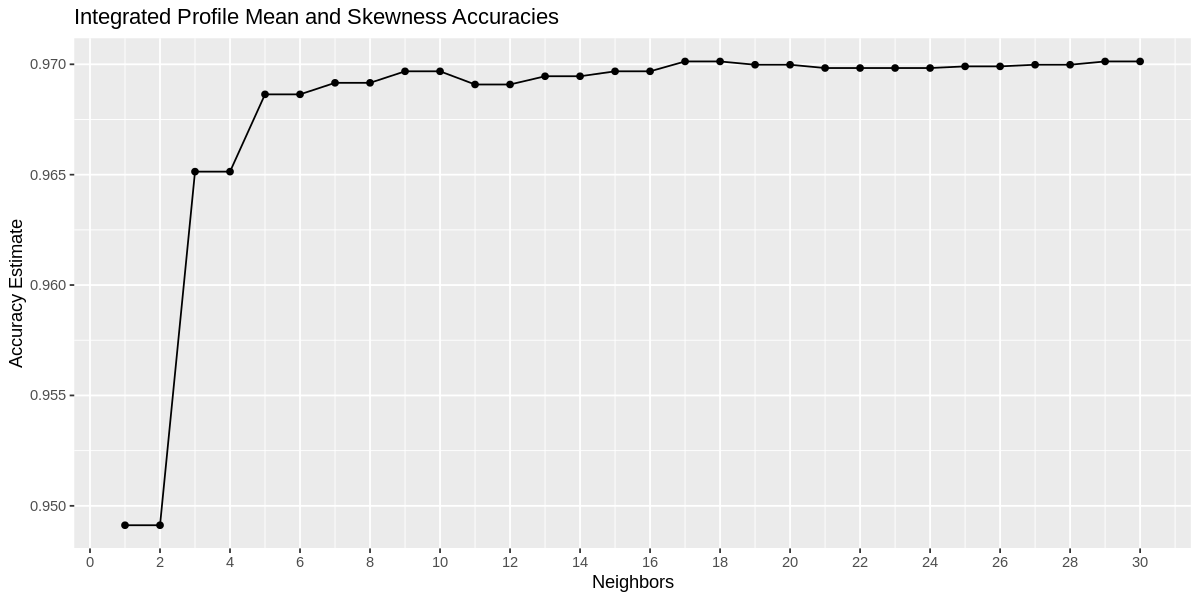

In [8]:
set.seed(19)
## Pairing 3
pulsar_recipe3 <- recipe(class ~ mean_ip + skewness_ip, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

ktib <- tibble(neighbors = 1:30)
knn_results3 <- workflow() %>%
      add_recipe(pulsar_recipe3) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ktib) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 5)
knn_plot3 <- ggplot(knn_results3, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Integrated Profile Mean and Skewness Accuracies") +
      scale_x_continuous(breaks = seq(0, 30, by = 2))
knn_plot3

k3 <- 3

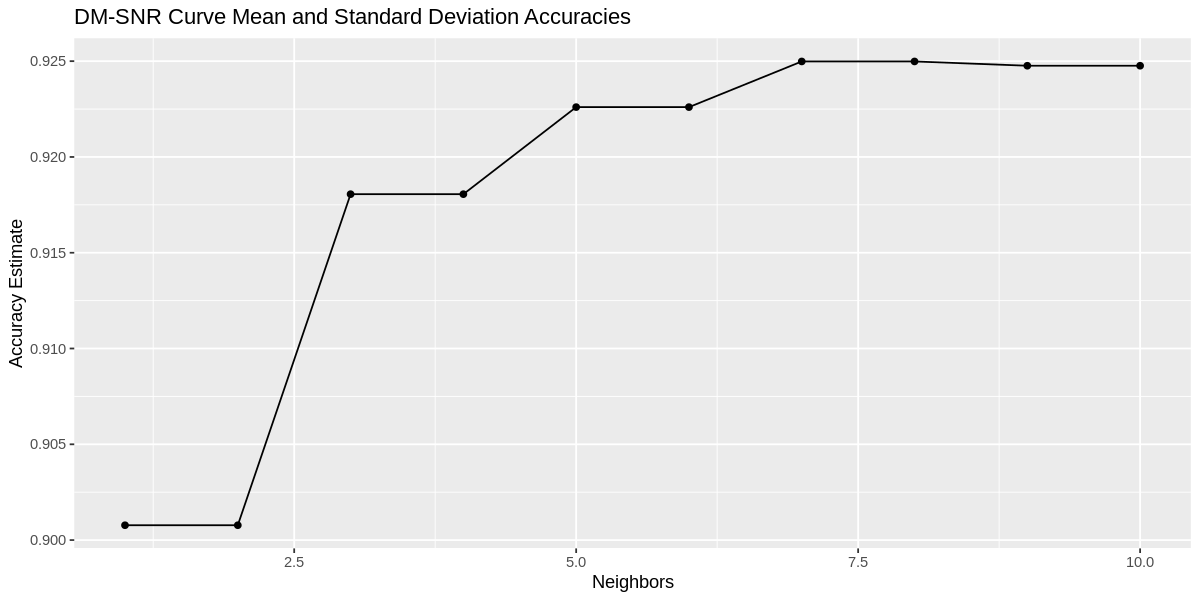

In [9]:
set.seed(19)
## Pairing 4
pulsar_recipe4 <- recipe(class ~ mean_dm + dev_dm, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

knn_results4 <- workflow() %>%
      add_recipe(pulsar_recipe4) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ks) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")

knn_plot4 <- ggplot(knn_results4, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("DM-SNR Curve Mean and Standard Deviation Accuracies")
knn_plot4

k4 <- 7

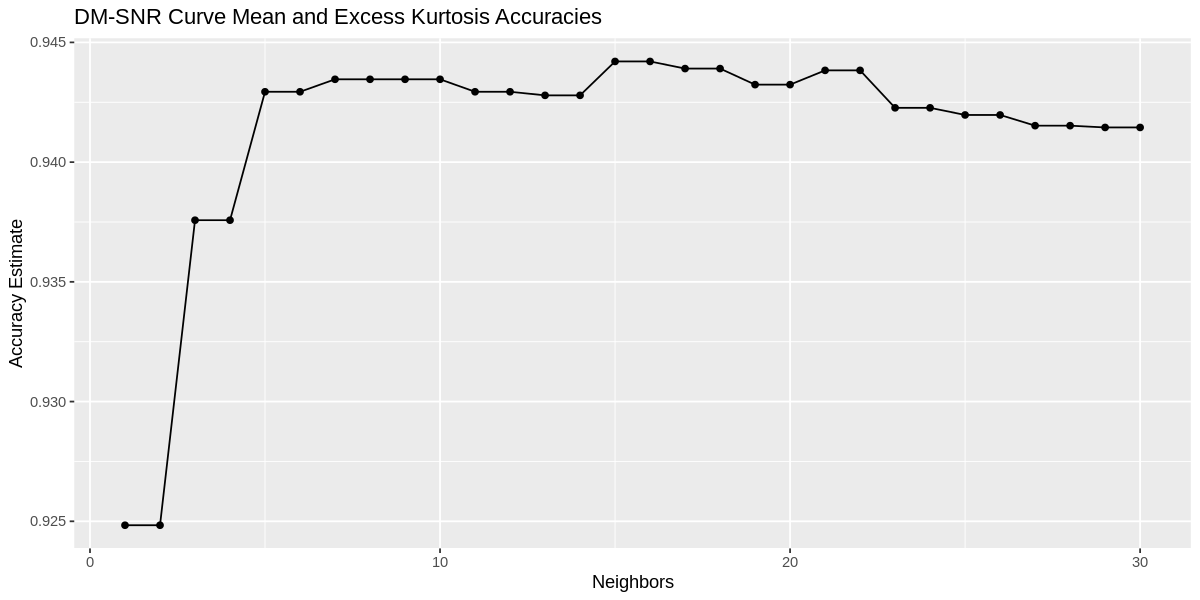

In [10]:
set.seed(19)
## Pairing 5
pulsar_recipe5 <- recipe(class ~ mean_dm + excess_dm, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

knn_results5 <- workflow() %>%
      add_recipe(pulsar_recipe5) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ktib) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")

knn_plot5 <- ggplot(knn_results5, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("DM-SNR Curve Mean and Excess Kurtosis Accuracies")
knn_plot5

k5 <- 3

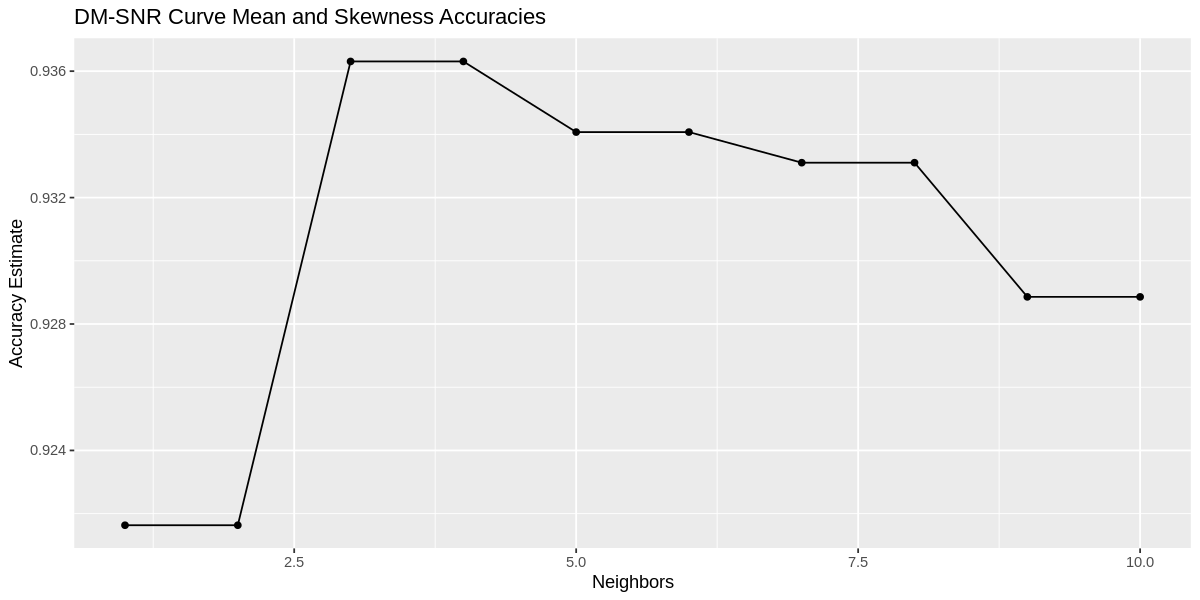

In [11]:
set.seed(19)
## Pairing 6
pulsar_recipe6 <- recipe(class ~ mean_dm + skewness_dm, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

knn_results6 <- workflow() %>%
      add_recipe(pulsar_recipe6) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ks) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")

knn_plot6 <- ggplot(knn_results6, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("DM-SNR Curve Mean and Skewness Accuracies")
knn_plot6

k6 <- 3

Running each model with the ideal number of neighbors to report accuracy.

In [12]:
## Skeleton

# knn_spec- <- nearest_neighbor(weight_func = 'rectangular', neighbors = k-) %>%
#                 set_engine('kknn') %>%
#                 set_mode('classification')
# acc_recipe- <- recipe(class ~ pr1 + pr2, data = pulsar_train) %>%
#                 step_center(all_predictors()) %>%
#                 step_scale(all_predictors())
# acc_fit- <- workflow() %>%
#       add_recipe(acc_recipe-) %>%
#       add_model(knn_spec-) %>%
#       fit(data = pulsar_train)
# pulsar_predict- <- predict(acc_fit-, pulsar_test) %>%
#                     bind_cols(pulsar_test) %>%
#                     metrics(truth = class, estimate = .pred_class) %>%
#                     filter(.metric == 'accuracy')
# pulsar_predict-

In [13]:
## Graph 1
knn_spec1 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k1) %>%
                set_engine('kknn') %>%
                set_mode('classification')
acc_recipe1 <- recipe(class ~ mean_ip + dev_ip, data = pulsar_train) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors())
acc_fit1 <- workflow() %>%
      add_recipe(acc_recipe1) %>%
      add_model(knn_spec1) %>%
      fit(data = pulsar_train)
pulsar_predict1 <- predict(acc_fit1, pulsar_test) %>%
                    bind_cols(pulsar_test) %>%
                    metrics(truth = class, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy')
pulsar_predict1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9642378


In [14]:
## Graph 2
knn_spec2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k2) %>%
                set_engine('kknn') %>%
                set_mode('classification')
acc_recipe2 <- recipe(class ~ mean_ip + excess_ip, data = pulsar_train) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors())
acc_fit2 <- workflow() %>%
      add_recipe(acc_recipe2) %>%
      add_model(knn_spec2) %>%
      fit(data = pulsar_train)
pulsar_predict2 <- predict(acc_fit2, pulsar_test) %>%
                    bind_cols(pulsar_test) %>%
#                     metrics(truth = class, estimate = .pred_class) %>%
#                     filter(.metric == 'accuracy') 
                    conf_mat(truth = class, estimate = .pred_class)
pulsar_predict2


          Truth
Prediction    0    1
         0 4041   63
         1   43  327

In [38]:
## Graph 3

knn_spec3 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k3) %>%
                set_engine('kknn') %>%
                set_mode('classification')
acc_recipe3 <- recipe(class ~ mean_ip + skewness_ip, data = pulsar_train) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors())
acc_fit3 <- workflow() %>%
      add_recipe(acc_recipe3) %>%
      add_model(knn_spec3) %>%
      fit(data = pulsar_train)
pulsar_predict3 <- predict(acc_fit3, pulsar_test) %>%
                    bind_cols(pulsar_test) %>%
                    metrics(truth = class, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy')
pulsar_predict3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.984


In [39]:
## Graph 4

knn_spec4 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k4) %>%
                set_engine('kknn') %>%
                set_mode('classification')
acc_recipe4 <- recipe(class ~ mean_dm + dev_dm, data = pulsar_train) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors())
acc_fit4 <- workflow() %>%
      add_recipe(acc_recipe4) %>%
      add_model(knn_spec4) %>%
      fit(data = pulsar_train)
pulsar_predict4 <- predict(acc_fit4, pulsar_test) %>%
                    bind_cols(pulsar_test) %>%
                    metrics(truth = class, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy')
pulsar_predict4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.92


In [40]:
## Graph 5

knn_spec5 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k5) %>%
                set_engine('kknn') %>%
                set_mode('classification')
acc_recipe5 <- recipe(class ~ mean_dm + excess_dm, data = pulsar_train) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors())
acc_fit5 <- workflow() %>%
      add_recipe(acc_recipe5) %>%
      add_model(knn_spec5) %>%
      fit(data = pulsar_train)
pulsar_predict5 <- predict(acc_fit5, pulsar_test) %>%
                    bind_cols(pulsar_test) %>%
                    metrics(truth = class, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy')
pulsar_predict5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.92


In [41]:
## Graph 6

knn_spec6 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k6) %>%
                set_engine('kknn') %>%
                set_mode('classification')
acc_recipe6 <- recipe(class ~ mean_dm + skewness_dm, data = pulsar_train) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors())
acc_fit6 <- workflow() %>%
      add_recipe(acc_recipe6) %>%
      add_model(knn_spec6) %>%
      fit(data = pulsar_train)
pulsar_predict6 <- predict(acc_fit6, pulsar_test) %>%
                    bind_cols(pulsar_test) %>%
                    metrics(truth = class, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy')
pulsar_predict6

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.912


The best pair of variables appear to be Mean and Excess Kurtosis from the Integrated Profile.

In [50]:
set.seed(19)
## Generating random tibble in range of original variables and predicting its class
random_mean <- runif(1, 5.8125000, 192.617188)
random_excess <- runif(1, -1.8760112, 7.879628)
random_point <- tibble(mean_ip = random_mean, excess_ip = random_excess)
random_point
point_prediction <- predict(acc_fit2, random_point)
point_prediction

mean_ip,excess_ip
<dbl>,<dbl>
27.69304,2.846008


.pred_class
<fct>
1


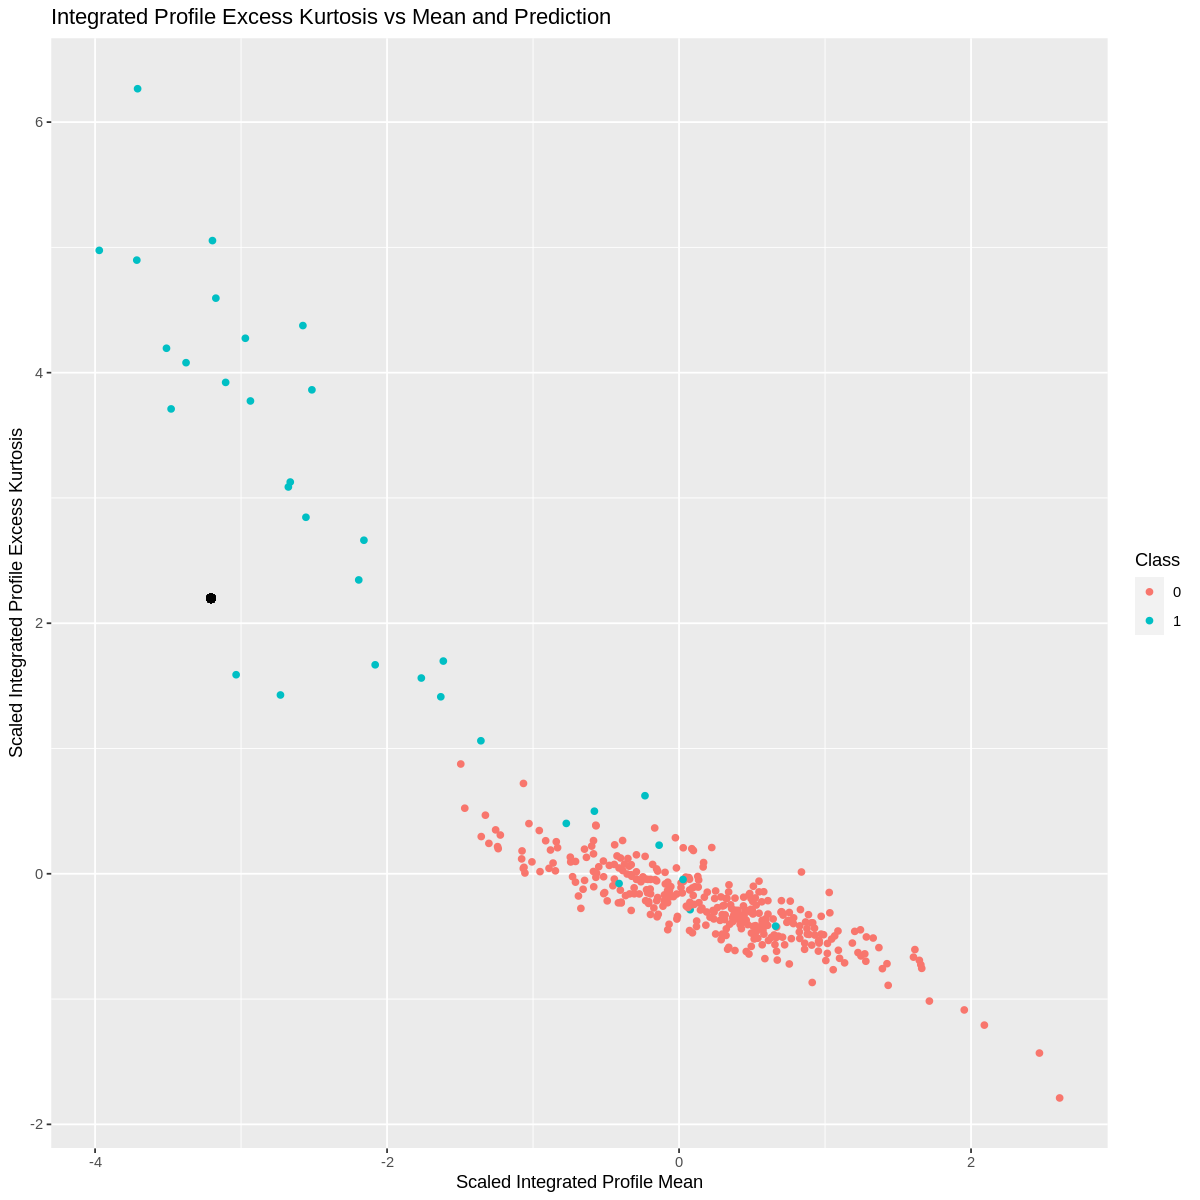

In [79]:
## Scaling data to plot
options(repr.plot.width=10, repr.plot.height=10)
scaled_data <- pulsar_train %>%
                mutate(scaled_mean_ip = scale(mean_ip, scale = TRUE, center = TRUE),
                       scaled_excess_ip = scale(excess_ip, scale = TRUE, center = TRUE))
predict_plot <- ggplot(scaled_data, aes(x = mean_ip, y = excess_ip, color = class)) +
                geom_point() +
                labs(x = "Integrated Profile Mean", y = "Integrated Profile Excess Kurtosis", color = 'Class') +
                ggtitle("Integrated Profile Excess Kurtosis vs Mean and Prediction") +
                geom_point(aes(x = random_mean, y = random_excess), color = "black", size = 2)
scaled_random_mean <- (random_mean - mean(pulsar_train$mean_ip))/sd(pulsar_train$mean_ip)
scaled_random_excess <- (random_excess - mean(pulsar_train$excess_ip))/sd(pulsar_train$excess_ip)
predict_plot_scaled <- ggplot(scaled_data, aes(x = scaled_mean_ip, y = scaled_excess_ip, color = class)) +
                geom_point() +
                labs(x = "Scaled Integrated Profile Mean", y = "Scaled Integrated Profile Excess Kurtosis", color = 'Class') +
                ggtitle("Integrated Profile Excess Kurtosis vs Mean and Prediction") +
                geom_point(aes(x = scaled_random_mean, y = scaled_random_excess), color = "black", size = 2)
predict_plot_scaled